In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coffee-leaf-diseases/train.csv
/kaggle/input/coffee-leaf-diseases/test.csv
/kaggle/input/coffee-leaf-diseases/test/nodisease/1626.jpg
/kaggle/input/coffee-leaf-diseases/test/nodisease/1161.jpg
/kaggle/input/coffee-leaf-diseases/test/nodisease/1173.jpg
/kaggle/input/coffee-leaf-diseases/test/nodisease/1211.jpg
/kaggle/input/coffee-leaf-diseases/test/nodisease/1167.jpg
/kaggle/input/coffee-leaf-diseases/test/nodisease/1222.jpg
/kaggle/input/coffee-leaf-diseases/test/nodisease/1124.jpg
/kaggle/input/coffee-leaf-diseases/test/nodisease/1162.jpg
/kaggle/input/coffee-leaf-diseases/test/nodisease/1166.jpg
/kaggle/input/coffee-leaf-diseases/test/nodisease/1297.jpg
/kaggle/input/coffee-leaf-diseases/test/nodisease/1144.jpg
/kaggle/input/coffee-leaf-diseases/test/nodisease/1125.jpg
/kaggle/input/coffee-leaf-diseases/test/nodisease/1171.jpg
/kaggle/input/coffee-leaf-diseases/test/nodisease/1243.jpg
/kaggle/input/coffee-leaf-diseases/test/nodisease/1172.jpg
/kaggle/input/coffee-leaf-

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, Conv2D, MaxPool2D,
    GlobalAveragePooling2D,
    BatchNormalization, Add
)
from tensorflow.keras.models import Model

In [56]:
train_dir = '/kaggle/input/coffee-leaf-diseases/train'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    rescale=1./255,

    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,

    brightness_range=(0.6, 1.4),
    channel_shift_range=20.0,

    fill_mode="nearest",
    validation_split=0.30
)
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)
num_classes = len(train_gen.class_indices)
print("Classes:", train_gen.class_indices)


Found 886 images belonging to 4 classes.
Found 378 images belonging to 4 classes.
Classes: {'miner': 0, 'nodisease': 1, 'phoma': 2, 'rust': 3}


In [57]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Add
)

class ResnetBlock(Model):
    def __init__(self, channels, down_sample=False, **kwargs):
        super().__init__(**kwargs)

        self.channels = channels
        self.down_sample = down_sample
        self.strides = [2, 1] if down_sample else [1, 1]

        self.conv1 = Conv2D(
            channels, 3,
            strides=self.strides[0],
            padding="same",
            kernel_initializer="he_normal"
        )
        self.bn1 = BatchNormalization()

        self.conv2 = Conv2D(
            channels, 3,
            strides=self.strides[1],
            padding="same",
            kernel_initializer="he_normal"
        )
        self.bn2 = BatchNormalization()

        if down_sample:
            self.res_conv = Conv2D(
                channels, 1,
                strides=2,
                padding="same",
                kernel_initializer="he_normal"
            )
            self.res_bn = BatchNormalization()
        else:
            self.res_conv = None
            self.res_bn = None

        self.add = Add()

    def call(self, x, training=False):
        shortcut = x

        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        if self.down_sample:
            shortcut = self.res_conv(shortcut)
            shortcut = self.res_bn(shortcut, training=training)

        x = self.add([x, shortcut])
        return tf.nn.relu(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "channels": self.channels,
            "down_sample": self.down_sample
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [58]:
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPool2D,
    GlobalAveragePooling2D, Dense
)

class ResNet18(Model):
    def __init__(self, num_classes, input_shape=(160, 160, 3), **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.input_shape_ = input_shape

        self.conv1 = Conv2D(
            64, 7,
            strides=2,
            padding="same",
            kernel_initializer="he_normal"
        )
        self.bn1 = BatchNormalization()
        self.pool1 = MaxPool2D(3, strides=2, padding="same")

        self.res1 = [ResnetBlock(64), ResnetBlock(64)]
        self.res2 = [ResnetBlock(128, True), ResnetBlock(128)]
        self.res3 = [ResnetBlock(256, True), ResnetBlock(256)]
        self.res4 = [ResnetBlock(512, True), ResnetBlock(512)]

        self.gap = GlobalAveragePooling2D()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)

        for block in self.res1 + self.res2 + self.res3 + self.res4:
            x = block(x, training=training)

        x = self.gap(x)
        return self.fc(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "input_shape": self.input_shape_
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [59]:
model = ResNet18(
    num_classes=num_classes,
    input_shape=(160,160,3)
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
dummy_input = tf.zeros((1, 160, 160, 3))
_ = model(dummy_input)
model.summary()

Model: "res_net18_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_140 (Conv2D)             │ (1, 80, 80, 64)        │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_140         │ (1, 80, 80, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_56 (ResnetBlock)   │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_57 (ResnetBlock)   │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_58 (ResnetBlock)   │ ?                      │       231,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_59 (ResnetBlock)   │ ?                      │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_60 (ResnetBlock)   │ ?                      │       921,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_61 (ResnetBlock)   │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_62 (ResnetBlock)   │ ?                      │     3,677,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_63 (ResnetBlock)   │ ?                      │     4,723,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (1, 4)                 │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,192,964 (42.70 MB)

 Trainable params: 11,183,364 (42.66 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [60]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=6, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", patience=3, factor=0.3
    )
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.3393 - loss: 2.2461 - val_accuracy: 0.2593 - val_loss: 61.8067 - learning_rate: 0.0010
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 838ms/step - accuracy: 0.5179 - loss: 1.1320 - val_accuracy: 0.2169 - val_loss: 10.4437 - learning_rate: 0.0010
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 841ms/step - accuracy: 0.5649 - loss: 0.9771 - val_accuracy: 0.2963 - val_loss: 5.0816 - learning_rate: 0.0010
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 842ms/step - accuracy: 0.6755 - loss: 0.7944 - val_accuracy: 0.3757 - val_loss: 1.9278 - learning_rate: 0.0010
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 845ms/step - accuracy: 0.7001 - loss: 0.7466 - val_accuracy: 0.2460 - val_loss: 2.1642 - learning_rate: 0.0010
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 853ms/step - accuracy: 0.7240 - loss: 0.6454 - val_accuracy: 0.4286 - val_loss: 2.0240 - learning_rate: 0.0010
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 855ms/step - accuracy: 0.7880 - loss: 0.5

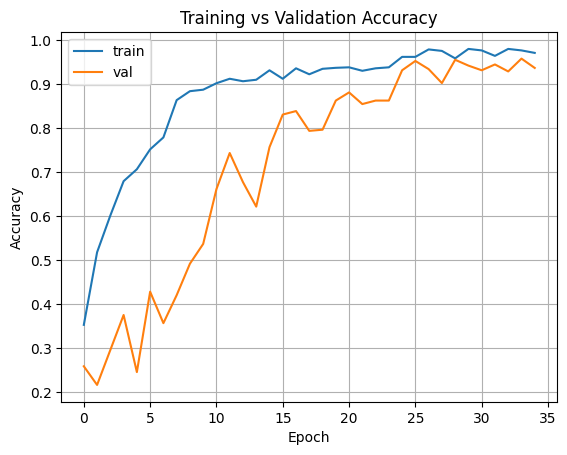

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.grid(True)
plt.show()

In [62]:
# Salva modelo
model.save_weights("resnet18.weights.h5")

In [63]:
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# =========================
# CONFIG
# =========================
TEST_DIR = "/kaggle/input/coffee-leaf-diseases/test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# =========================
# TEST GENERATOR
# =========================
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_names = list(test_gen.class_indices.keys())

# =========================
# PREDICTIONS
# =========================
y_prob = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes

# =========================
# METRICS
# =========================
acc = accuracy_score(y_true, y_pred)

precision_macro = precision_score(y_true, y_pred, average="macro")
precision_weighted = precision_score(y_true, y_pred, average="weighted")

recall_macro = recall_score(y_true, y_pred, average="macro")
recall_weighted = recall_score(y_true, y_pred, average="weighted")

f1_macro = f1_score(y_true, y_pred, average="macro")
f1_weighted = f1_score(y_true, y_pred, average="weighted")

auc_macro = roc_auc_score(
    y_true,
    y_prob,
    multi_class="ovr",
    average="macro"
)

# =========================
# OUTPUT
# =========================
print("\n📊 MÉTRICAS NO TEST SET")
print(f"Accuracy             : {acc:.4f}")
print(f"Precision (macro)    : {precision_macro:.4f}")
print(f"Precision (weighted) : {precision_weighted:.4f}")
print(f"Recall (macro)       : {recall_macro:.4f}")
print(f"Recall (weighted)    : {recall_weighted:.4f}")
print(f"F1-score (macro)     : {f1_macro:.4f}")
print(f"F1-score (weighted)  : {f1_weighted:.4f}")
print(f"AUC (macro, OVR)     : {auc_macro:.4f}")

print("\n📋 CLASSIFICATION REPORT")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=class_names
    )
)

print("\n🧩 CONFUSION MATRIX")
print(confusion_matrix(y_true, y_pred))


Found 400 images belonging to 4 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 362ms/step

📊 MÉTRICAS NO TEST SET
Accuracy             : 0.9575
Precision (macro)    : 0.9604
Precision (weighted) : 0.9581
Recall (macro)       : 0.9549
Recall (weighted)    : 0.9575
F1-score (macro)     : 0.9571
F1-score (weighted)  : 0.9573
AUC (macro, OVR)     : 0.9959

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

       miner       0.97      0.94      0.95       128
   nodisease       0.94      0.97      0.95       116
       phoma       0.95      1.00      0.97        96
        rust       0.98      0.92      0.95        60

    accuracy                           0.96       400
   macro avg       0.96      0.95      0.96       400
weighted avg       0.96      0.96      0.96       400


🧩 CONFUSION MATRIX
[[120   7   0   1]
 [  0 112   4   0]
 [  0   0  96   0]
 [  4   0   1  55]]
